# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import some additional stuff
import sys
from sklearn import preprocessing as pp
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pandas.api.types import is_float_dtype

# [TODO] Create and import helper_functions as h

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Configure Some Verbose Parameters

In [2]:
# Set the verbosity of the Notebook to [0|1|2|..]
VERBOSE = 2

# Set display options to show all rows
pd.set_option('display.max_rows', 100)

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

#### Loading the datasets

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep=';') 

#### Getting to know the **General Population** dataset

In [4]:
if VERBOSE > 0:
    display(azdias)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,-1,3,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


In [5]:
if VERBOSE > 0:
    # Get the type of each column
    display(azdias.dtypes)

AGER_TYP                   int64
ALTERSKATEGORIE_GROB       int64
ANREDE_KZ                  int64
CJT_GESAMTTYP            float64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
FINANZTYP                  int64
GEBURTSJAHR                int64
GFK_URLAUBERTYP          float64
GREEN_AVANTGARDE           int64
HEALTH_TYP                 int64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
LP_FAMILIE_FEIN          float64
LP_FAMILIE_GROB          float64
LP_STATUS_FEIN           float64
LP_STATUS_GROB           float64
NATIONALITAET_KZ           int64
PRAEGENDE_JUGENDJAHRE      int64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
SEMIO_ERL 

In [6]:
if VERBOSE > 0:
    display(azdias.describe())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
if VERBOSE > 0: 
    # Get the number of unique values in each column
    unique_values = azdias.nunique()
    print("These are the number of unique values per column:\n")
    display(unique_values)

These are the number of unique values per column:



AGER_TYP                    5
ALTERSKATEGORIE_GROB        5
ANREDE_KZ                   2
CJT_GESAMTTYP               6
FINANZ_MINIMALIST           5
FINANZ_SPARER               5
FINANZ_VORSORGER            5
FINANZ_ANLEGER              5
FINANZ_UNAUFFAELLIGER       5
FINANZ_HAUSBAUER            5
FINANZTYP                   6
GEBURTSJAHR               117
GFK_URLAUBERTYP            12
GREEN_AVANTGARDE            2
HEALTH_TYP                  4
LP_LEBENSPHASE_FEIN        41
LP_LEBENSPHASE_GROB        13
LP_FAMILIE_FEIN            12
LP_FAMILIE_GROB             6
LP_STATUS_FEIN             10
LP_STATUS_GROB              5
NATIONALITAET_KZ            4
PRAEGENDE_JUGENDJAHRE      16
RETOURTYP_BK_S              5
SEMIO_SOZ                   7
SEMIO_FAM                   7
SEMIO_REL                   7
SEMIO_MAT                   7
SEMIO_VERT                  7
SEMIO_LUST                  7
SEMIO_ERL                   7
SEMIO_KULT                  7
SEMIO_RAT                   7
SEMIO_KRIT

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

##### Step 1.1.1a: Getting to know the **Feature Summary** dataset
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data.


In [8]:
if VERBOSE > 0:
    display(feat_info)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


#### Step 1.1.1b: Convert Missing Value Codes to NaNs
Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.


In [9]:
def encode_missing_values(feat_info, verbose=0):
    """Creates a dataframe that encodes the missing or unknown values per feature.
        
    Args:
        feat_info (df): A DF containing a summary of feature attributes and information about the codes for missing or unknown values.
        verbose (int): The verbosity level.
    
    Return:
        A dataframe with the missing and unknown values stored as columns and per feature.
        E.g., { 
         'attribute' : [ 'AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ'],
                 '0' : [       '-1',                    '0',      'None'],
                 '1' : [       '-1',                    '0',         '9'],
                 '2' " [       '-1',                    '0',      'None'] }      
    """
    # Retrieve the codes for the missing and unknown values
    df_codes = feat_info[['attribute', 'missing_or_unknown']].copy()

    # Remove the '[' and ']' characters from the 'missing_or_unknkown' column 
    df_codes['missing_or_unknown'] = df_codes['missing_or_unknown'].str.replace('[', '').str.replace(']', '')

    # Split the values in 'missing_or_unknown' column and expand to new columns
    df_tmp = df_codes['missing_or_unknown'].str.split(',', expand=True) # .apply(pd.to_numeric)

    # We may have some empty strings left after the splitting. 
    # Let's turn them into 'None' instead.  
    df_tmp.replace('', None, inplace=True)

    # Concatenate back into 'df_codes' and drop 'missing_or_unknown' column
    df_codes = pd.concat([df_codes, df_tmp], axis=1)
    df_codes = df_codes.drop('missing_or_unknown', axis=1)
    
    if verbose >= 1:
        print(f"[encode_missing_values] - This is the dataframe that encodes the missing or unknown values per feature")
        print(df_codes)  
    
    return df_codes

In [10]:
###############################################################################
##  Encode Missing Values                                                    ##
###############################################################################
df_codes = encode_missing_values(feat_info, verbose=VERBOSE)

[encode_missing_values] - This is the dataframe that encodes the missing or unknown values per feature
                attribute     0     1     2
0                AGER_TYP    -1     0  None
1    ALTERSKATEGORIE_GROB    -1     0     9
2               ANREDE_KZ    -1     0  None
3           CJT_GESAMTTYP     0  None  None
4       FINANZ_MINIMALIST    -1  None  None
5           FINANZ_SPARER    -1  None  None
6        FINANZ_VORSORGER    -1  None  None
7          FINANZ_ANLEGER    -1  None  None
8   FINANZ_UNAUFFAELLIGER    -1  None  None
9        FINANZ_HAUSBAUER    -1  None  None
10              FINANZTYP    -1  None  None
11            GEBURTSJAHR     0  None  None
12        GFK_URLAUBERTYP  None  None  None
13       GREEN_AVANTGARDE  None  None  None
14             HEALTH_TYP    -1     0  None
15    LP_LEBENSPHASE_FEIN     0  None  None
16    LP_LEBENSPHASE_GROB     0  None  None
17        LP_FAMILIE_FEIN     0  None  None
18        LP_FAMILIE_GROB     0  None  None
19         LP_STA

In [11]:
def convert_missing_values_codes_to_nan(df, df_codes, verbose=0):
    """
    Convert missing value codes to NaNs.
        
    Args:
        df (df): The dataframe to process.
        df_codes (df): A dataframe containing the missing and unknown values stored as columns and per feature.
        verbose (int): The verbosity level.
    
    Return:
        Two dataframes: 
          1) the processsed dataframe with NaNs in place of missing values. 
          2) a dataframe that keeps track of the number of missing values per column.
    
    Note:
        The format of the DF that keep track of the missing values per column is:
            ['feature', 'missing_values']
    """

    # Make a copy of the incoming dataframe
    df_nan = df.copy()
    
    # Create an empty DF to count the number of missing values
    df_miss = pd.DataFrame(columns=['feature', 'missing_values'])
       
    # Iterate over the rows of the    
    for r in range(df_codes.shape[0]-1):
        feature_count = 0
        feature = df_codes.iloc[r]['attribute']
        
        # Iterate over the rows and columns
        for c in range(0, df_codes.shape[1]-1):
            if df_codes.iloc[r][c] is None:
                break;
            str_code = df_codes.iloc[r][c]
            
            # Try converting to code to integer
            is_int = True
            try:
                code = int(str_code)
            except ValueError:
                is_int = False
            
            if is_int:
                # Count the number of occurences of this 'code' in the dataset
                count = df[feature].value_counts().get(code, 0)
                if count > 0:
                    # Replace any occurrence of this 'code' with NaN
                    df_nan[feature].replace(code, np.nan, inplace=True)                
                    feature_count += count
                if verbose > 2:
                    print(f"[INFO] {feature} has {count} occurrences of {code}")
            else:
                count = df[feature].value_counts().get(str_code, 0)
                if count > 0:
                    #OBSOLETE-20230804 Replace any occurrence of this 'str_code' with NaN
                    #OBSOLETE-20230804 df_nan[feature].replace(str_code, np.nan, inplace=True)
                    # Count but do not replace this occurrence now (we will handle it later)
                    feature_count += count
                if verbose > 2:
                    print(f"[INFO] {feature} has {count} occurrences of {str_code}")

        # Keep track of the number of missing values
        df_miss.loc[len(df_miss)] = {'feature': feature, 'missing_values': feature_count}
                
        if verbose > 2:
            print(f"[INFO] {feature} has a total of {feature_count} NaN values")
            
    return df_nan, df_miss

In [12]:
###############################################################################
##  Convert Missing Values to NANs                                           ##
###############################################################################
azdias_nan, azdias_miss = convert_missing_values_codes_to_nan(azdias, df_codes)
print(f"[INFO] This is how the \'azdias_miss\' dataframe looks like.")
print(azdias_miss.head(5))
print(f"[INFO] And this is the head of \'azdias_nan\' dataframe.")
azdias_nan.head(5)

[INFO] This is how the 'azdias_miss' dataframe looks like.
                feature  missing_values
0              AGER_TYP          685843
1  ALTERSKATEGORIE_GROB            2881
2             ANREDE_KZ               0
3         CJT_GESAMTTYP               0
4     FINANZ_MINIMALIST               0
[INFO] And this is the head of 'azdias_nan' dataframe.


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Handle Missing Data in Each Column

##### Step 1.1.2a: Assess the Missing Data per Column
In section [1.1.1b](#step-111b-convert-missing-value-codes-to-nans) we returned a dataframe containing the number of missing values per feature. 

The first plot below shows a graphical view of these missing values. The `green` line represent a configurable threshold indicating a percentage of missing values per feature (in this case `15%`). Note that you can also display the content of this dataframe by setting the appropriate verbosity level.

The second plot shows a stair graph with a  `bin-size` configured according to the the same threshold of `15%` missing values per feature.

FYI - This is the list of features that have more than 15% (133683) of missing values:
         feature  missing_values
0       AGER_TYP          685843
11   GEBURTSJAHR          392318
40      TITEL_KZ          815562
43      ALTER_HH          236768
55   OST_WEST_KZ          168545
64  KBA05_BAUMAX          343200


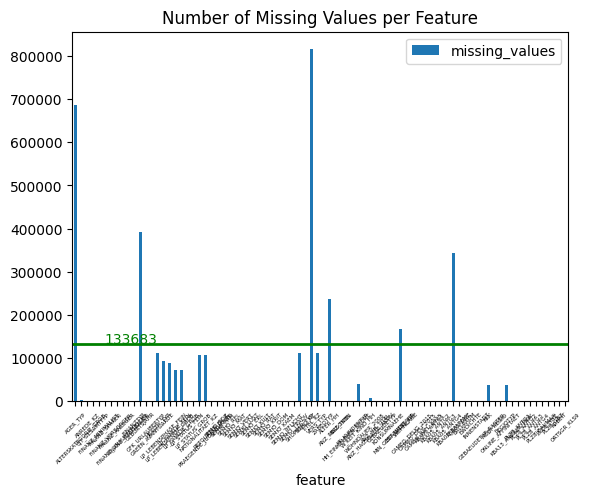

In [13]:
# Create a bar plot
plot = azdias_miss.plot(kind='bar', 
                        title='Number of Missing Values per Feature',
                        x='feature', y='missing_values')

# Visualize and list the features that have more than a certain 
# number of missing values (as a percentage of the total values)     
miss_percent = 15.0
miss_threshold = (int)(azdias_nan.shape[0] * miss_percent/100) 

print(f"FYI - This is the list of features that have more than {miss_percent:.0f}% ({miss_threshold}) of missing values:")
print(azdias_miss[azdias_miss['missing_values'] >= miss_threshold])
plot.axhline(y=miss_threshold, color= 'green', linewidth=2, 
             label=miss_threshold)
plt.text(x=5, y=miss_threshold, s=miss_threshold, color='green')

# Rotate the x-axis labels by 45 degrees and dercreas font size
plt.xticks(rotation=45, fontsize=4)

if VERBOSE > 2:
    print(azdias_miss)


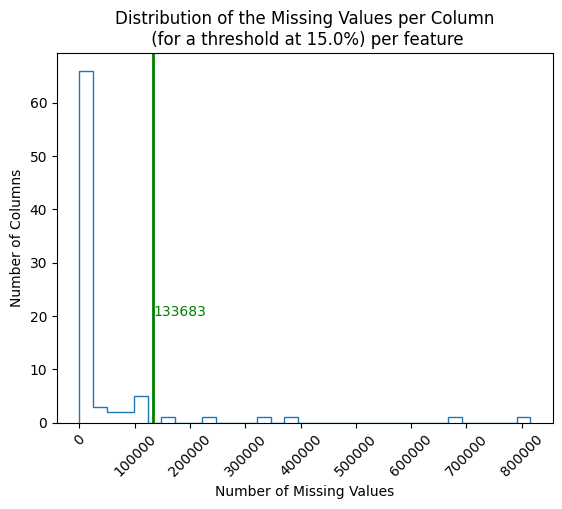

In [14]:
# Next, let's visualize the distribution of those missing values
num_bins = (int)(100/miss_percent*5)

counts, bins = np.histogram(azdias_miss['missing_values'], bins=num_bins)
plt.title(f"Distribution of the Missing Values per Column\n (for a threshold at {miss_percent}%) per feature")
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Columns')
plt.stairs(counts, bins)

# Rotate the x-axis labels by 45 degrees and decrease font size
plt.xticks(rotation=45, fontsize=10)

plt.axvline(x=miss_threshold, color='green', linewidth=2,)
plt.text(x=miss_threshold, y=20, s=miss_threshold, color='green')

if VERBOSE > 3:
    print(bins)

##### Step 1.1.2b: Removing the Outlier Columns
According to the 2 above graphs, we will remove all the features that have more than `miss_percent` missing values.

In [15]:
def remove_outliers_columns(df, df_miss, fi, col_threshold=15.0, verbose=0):
    """
    Remove the outlier columns from the dataset and updates the feature-information dataframe accordingly. 
        
    Args:
        df      (df): The dataset to process.
        df_miss (df): A dataframe that contains the number of missing values per column.
        fi      (df): A dataframe containing feature-info about the encoding of the dataset. 
        col_threshold (float, optional): The threshold specifying the acceptable percentage of missing values per column (e.g. 15.0%). Any column that has more tna 'percentage' of missing values will be dropped.
        verbose (int): The verbosity level.
        
    Returns:
        df_roc (df): The dataset without outlier columns.
        fi_roc (df): The feature-information with removed feature attributes.
        dropped_cols(str): A list with the names of the removed columns. 
    """
    assert col_threshold >= 0.0 and col_threshold < 100.0
    miss_threshold = (int)(df.shape[0] * col_threshold/100) 
    dropped_cols = []
    
    # Create a copy of the incoming dataset and feature-info  
    #  Note: '_roc' stands for Removed Outliers Columns.   
    df_roc = df.copy()
    fi_roc = fi.copy() 

    # Retrieve the names of the features to remove
    drop_candidates = (df_miss[df_miss['missing_values'] >= miss_threshold])

    # Drop columns
    for f in drop_candidates.index:
        feature = drop_candidates['feature'][f]
        if verbose >= 2:
            print(f"[remove_outliers_columns] Dropping feature \'{feature}\' from the dataset and feature-info.")
        df_roc = df_roc.drop([feature], axis=1)
        if feature not in dropped_cols:
            dropped_cols.append(feature)
    
        # Remove the corresponding row in the feature summary
        fi_roc = fi_roc.drop(fi_roc[fi_roc['attribute'] == feature].index) 
        
    if verbose > 0:
        print(f"\n[INFO] The shape of the dataset is now {df_roc.shape}")
        print(f"[INFO] The shape of the feat_info is now {fi_roc.shape}") 

    return df_roc, fi_roc, dropped_cols

In [16]:
###############################################################################
##  Remove the Outlier Columns                                               ##
###############################################################################
azdias_nan_roc, feat_info_roc, dropped_cols = remove_outliers_columns(azdias_nan, 
                                    azdias_miss, feat_info, col_threshold=15.0,
                                    verbose=1)
print("[INFO] The list of the removed outliers is: \n\t", dropped_cols)


[INFO] The shape of the dataset is now (891221, 79)
[INFO] The shape of the feat_info is now (79, 4)
[INFO] The list of the removed outliers is: 
	 ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'OST_WEST_KZ', 'KBA05_BAUMAX']


#### Discussion 1.1.2c: Missing Data in Each Column
In section [1.1.2a](#step-112a-assess-the-missing-data-per-column) we created two graphs to investigate how missing data were distributed  across different columns of the dataset.

With the 1st graph, we observe that a few features have a large amount of missing values. By setting a threshold value at 15% of the total number of values in a column, we identify 6 features **('AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'OST_WEST_KZ' 'KBA05_BAUMAX')** that accumulate large amounts of missing values (2nd graph). We therefore decided to consider these features as outliers, and to remove them from the current dataset.          

#### Step 1.1.3: Assess Missing Data in Each Row
Here we perform a similar assessment of missing data for the rows of the dataset to figure out how much data is missing in each row. 

##### Step 1.1.3a: How much data is missing in each row
In this section, we compute the number of missing data in each row and we plot the corresponding distribution.

Text(26, 100000, '25 (or 31% miss per row)')

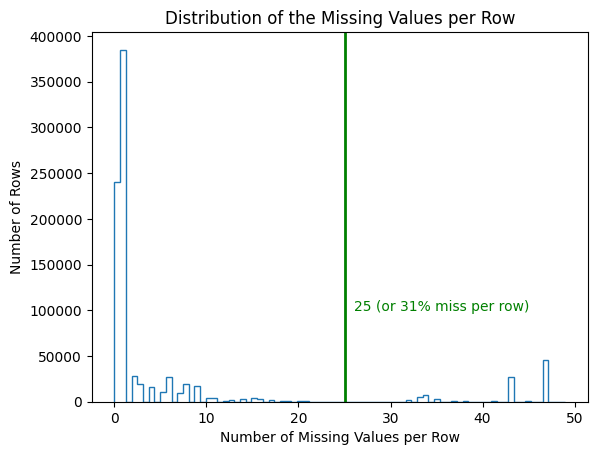

In [17]:
###############################################################################
##  Compute the number of missing data in each row                           ##
###############################################################################

nans_per_row = azdias_nan_roc.isna().sum(axis=1)
if VERBOSE > 2:
    print(nans_per_row)

# Let's plot the distribution of the number of missing values per row
# to get a bettre grasp on the trend
num_bins = azdias_nan_roc.shape[1]
counts, bins = np.histogram(nans_per_row, bins=num_bins)
plt.title(f"Distribution of the Missing Values per Row")
plt.xlabel('Number of Missing Values per Row')
plt.ylabel('Number of Rows')
plt.stairs(counts, bins)

cut = 25
row_threshold = (cut / azdias_nan_roc.shape[1]) * 100 
plt.axvline(x=cut, color='green', linewidth=2,)
text = str(cut) + " (or " + str(int(row_threshold)) + "% miss per row)"
plt.text(x=cut+1, y=100000, s=text, color='green')


##### Step 1.1.3b: Divide the dataset into two subsets
From the above distribution, we can clearly see two groups of rows with different numbers of missing values. Let's define a `threshold` for missing values and split the dataset into two subsets: 
- one for data points that are above this threshold and,
- a second subset for points below that threshold.

In [18]:
def remove_outliers_rows(df, row_threshold=32.0, verbose=0):
    """
    Remove the outlier rows from the dataset. 
     
    Args:
        df (df): The dataset to process. 
        row_threshold (float, optional): The threshold specifying the acceptable
                 percentage of missing values per row (e.g. 32.0%). Any row that
                 has more than 'percentage' of missing values per row will be
                 dropped.
        verbose (int): The verbosity level.
    
    Returns:
        df_lo_miss: The dataset with few outlier rows.
        df_hi_miss: A dataframe made of rows with many outliers.
    """
    miss_threshold = (int)(df.shape[1] * row_threshold / 100)

    # Subset with less than 'miss_threshold' NaNs
    df_lo_miss = df[df.isnull().sum(axis=1) <= miss_threshold]

    # Subset with more than 'miss_threshold' NaNs
    df_hi_miss = df[df.isnull().sum(axis=1) > miss_threshold]

    if verbose:
        print(f"The shape of the 'low'  subset is {df_lo_miss.shape}")
        print(f"The shape of the 'high' subset is {df_hi_miss.shape}")
  
    return df_lo_miss, df_hi_miss

In [19]:
###############################################################################
##  Divide the Dataset into Two Subsets                                      ##
###############################################################################

# Define a threshold for the split. This threshold specifies the acceptable
# number of missing values per row, as a percentage of the number of columns.
row_threshold = 32.0

azdias_nan_roc_lo_miss, azdias_nan_roc_hi_miss = remove_outliers_rows(
                                                 azdias_nan_roc, row_threshold,
                                                 verbose=VERBOSE)

The shape of the 'low'  subset is (797936, 79)
The shape of the 'high' subset is (93285, 79)


##### Step 1.1.3c: Compare the distribution of values among columns of the two subsets
In order to know decide a way to handle the outlier rows, we can compare the distribution of data values of a few columns in the two subsets, and see how much they differ.

We start by finding and selecting five columns with zero or low number of missing values. For information,  we selected the following 5 features:
   - **ANZ_PERSONEN**       (Number of adults in household)
   - **HH_EINKOMMEN_SCORE** (Estimated household net income)
   - **WOHNLAGE**           (Neighborhood quality (or rural flag))
   - **LP_STATUS_FEIN**     (Social status, fine scale)
   - **ARBEIT**             (Share of unemployment in community)

In [20]:
###############################################################################
##  Print columns with very low number of missing values                     ##
###############################################################################

miss_percent = 1.0
miss_threshold = (int)(azdias_nan_roc.shape[0] * miss_percent/100) 
print(f"FYI - This is the list of features that have less than {miss_percent:.0f}% ({miss_threshold}) of missing values:")
print(azdias_miss[azdias_miss['missing_values'] <= miss_threshold].sort_values(by='missing_values'))

FYI - This is the list of features that have less than 1% (8912) of missing values:
                  feature  missing_values
45              ANZ_TITEL               0
44           ANZ_PERSONEN               0
81               PLZ8_GBZ               0
46     HH_EINKOMMEN_SCORE               0
47           KK_KUNDENTYP               0
49         WOHNDAUER_2008               0
80               PLZ8_HHZ               0
51           ANZ_HH_TITEL               0
52            GEBAEUDETYP               0
53            KONSUMNAEHE               0
54       MIN_GEBAEUDEJAHR               0
56               WOHNLAGE               0
79            PLZ8_BAUMAX               0
42               ZABEOTYP               0
78             PLZ8_ANTG4               0
60            KBA05_ANTG1               0
61            KBA05_ANTG2               0
62            KBA05_ANTG3               0
63            KBA05_ANTG4               0
65              KBA05_GBZ               0
66               BALLRAUM         

In [21]:
def plot_countplot_grid(df0, df1, features):
    """
    Plot a grid comparing a list of feature counts of observations between two dataframes.

    Args:
        df0 (df): A dataframe with low numbers of missing values.
        df1 (df): A dataframe with higher number of missing values.
        feature (string): A list of feature column names to compare.
    """
    sns.set_theme(style="darkgrid")
    
    grid_cols = 2 # Always
    grid_rows = len(features)
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 4*grid_rows), sharey=True)
    fig.suptitle('Counts of observations per feature\n LOW (left) vs HIGH (right) Number of Missing Values')
  
    for f in range(axes.shape[0]):
        # 1st Dataframe
        sns.countplot(ax=axes[f, 0], data=df0, x=df0[features[f]])
        # 2nd Dataframe
        sns.countplot(ax=axes[f, 1], data=df1, x=df1[features[f]])


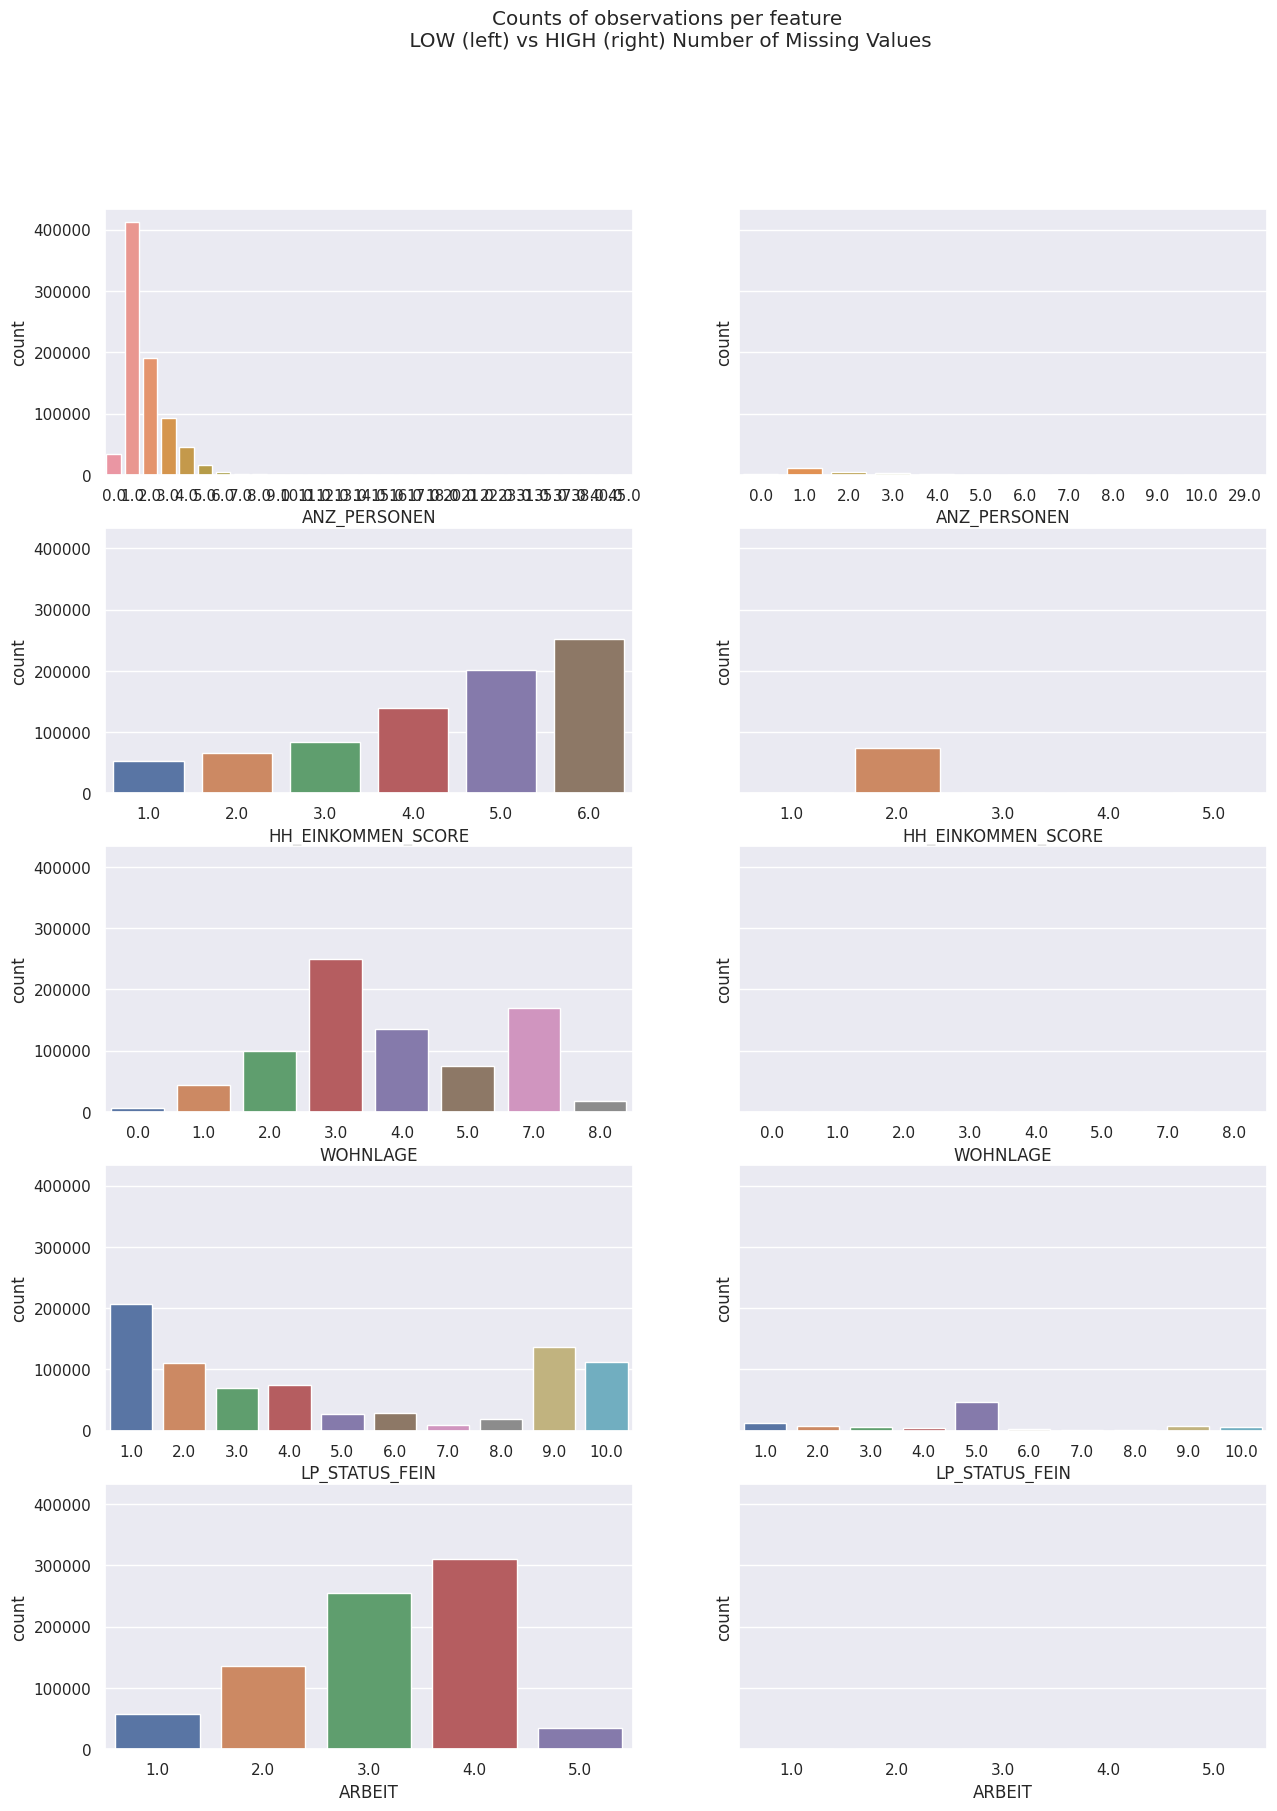

In [22]:
################################################################################
##  Compare the distribution of values for at least five columns where there  ##
##              are no or few missing values, between the two subsets.        ##
################################################################################

# The selected 5 features are: 
#   ANZ_PERSONEN       = Number of adults in household
#   HH_EINKOMMEN_SCORE = Estimated household net income
#   WOHNLAGE           = Neighborhood quality (or rural flag)
#   LP_STATUS_FEIN     = Social status, fine scale
#   ARBEIT             = Share of unemployment in community

plot_countplot_grid(azdias_nan_roc_lo_miss, 
                    azdias_nan_roc_hi_miss, 
                    ["ANZ_PERSONEN", "HH_EINKOMMEN_SCORE", "WOHNLAGE", "LP_STATUS_FEIN", "ARBEIT"])

#### Discussion 1.1.3: Assess Missing Data in Each Row

The above comparison shows two trends:
- the distributions of the features with many missing values if often non-existent due to lack of data and, 
- when a distribution exists, its shape looks different from the one with few or no missing values but the amplitude of this difference is only a small fraction of the one with few or no missing values.

This suggest that we can can go and drop the rows from the second group as they won't significantly impact the analysis. Therefore, **we will continue our analysis using just the subset of the data with few or no missing values.**

### Step 1.2: Select and Re-Encode Features

```
Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. 

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!
```

#### Step 1.2.1a: Identify the Various Data Types
We can retrieve the various data types used in the feature columns by looking at 
the third column of the feature summary (`feat_info_roc`). 

In [23]:
###############################################################################
##  Identify the number of different features used by the dataset            ## 
##           and get the counts of each data                                 ##
###############################################################################
data_types = feat_info_roc['type'].value_counts().to_dict()

print(f"They are {len(data_types)} different data types in the dataset and the usage is as follows:")
for key, value in data_types.items():
    print(f"\t- {key} \t is used by {value:2d} feature(s)")

They are 4 different data types in the dataset and the usage is as follows:
	- ordinal 	 is used by 49 feature(s)
	- categorical 	 is used by 18 feature(s)
	- mixed 	 is used by  6 feature(s)
	- numeric 	 is used by  6 feature(s)


#### Step 1.2.1b: Numeric and Inteval Data Handling
The numeric and interval data features will be kept without changes.

#### Step 1.2.1c: Re-Encode Categorical Features
In this step, we identify which of the categorical variables are binary, which are
multi-level, and which one needs to be re-encoded.

[INFO] At this point of the data wrangling, the current raw dataset is referred
to as: 'azdias_nan_roc_lo_miss'.

In [24]:
def retrieve_categorical_features(df, fi, verbose=0):
    """
    Return a dataframe containing the categorical variables.
   
    Args:
        df (df): The dataframe to investigate from.
        fi (df): A dataframe containing feature-info about the encoding of the dataset. 
        verbose (int): The verbosity level.
    Return:
        The categorical variables as a dataframe.
    """
    
    # List the categorical variables
    categorical_features = fi[fi['type'] == 'categorical'].copy()

    # Add a column with the number of unique values per feature and populate it
    categorical_features['unique_values'] = 0

    for index, row in categorical_features.iterrows():
        attrib_name = row['attribute']
        if attrib_name in df:
            num_unique = df[attrib_name].nunique()
            if verbose > 2:
                print(f"Attribute {attrib_name} has {num_unique} unique values")
            categorical_features.loc[index, 'unique_values'] = num_unique

    # Sort the dataframe by the 'unique_values' column 
    categorical_features = categorical_features.sort_values(by='unique_values', ascending=False)

    if verbose:
        print(f"[retrieve_categorical_features] - This is a summary of the categorical variables and the number of unique values:")
        display(categorical_features)

    return categorical_features

In [25]:
###############################################################################
##  Identify the categorical variables                                       ##
###############################################################################
categorical_features = retrieve_categorical_features(azdias_nan_roc_lo_miss, 
                                                     feat_info_roc, verbose=VERBOSE)

[retrieve_categorical_features] - This is a summary of the categorical variables and the number of unique values:


,attribute,information_level,type,missing_or_unknown,unique_values
58,CAMEO_DEU_2015,microcell_rr4,categorical,[XX],45
12,GFK_URLAUBERTYP,person,categorical,[],12
17,LP_FAMILIE_FEIN,person,categorical,[0],11
57,CAMEO_DEUG_2015,microcell_rr4,categorical,"[-1,X]",10
19,LP_STATUS_FEIN,person,categorical,[0],10
52,GEBAEUDETYP,building,categorical,"[-1,0]",7
42,ZABEOTYP,person,categorical,"[-1,9]",6
10,FINANZTYP,person,categorical,[-1],6
3,CJT_GESAMTTYP,person,categorical,[0],6
47,KK_KUNDENTYP,household,categorical,[-1],6


**From the above above summary, we identify 3 groups of categorical data**
- A group of 3  binary (two-level) categoricals that we are going to re-encode as as number, unless they already take numeric values.
- A group of 5 multi-level categoricals with 3 to 6 unique values. Given The relatively low number of levels, one can consider to encode these values with
a one-hot-encoder.
- A group of 5 multi-level categoricals with 7 to 45 unique values that we are simply going to drop.

In [26]:
def re_encode_categorical_features(df, fi, cat_features, verbose=0):
    """
    Re-encode the categorical features as as number, unless they already take numeric values. 
    
    Args:
        df (df): The dataset to process.
        cat_features (df): The categorical variables as a dataframe.
        fi (df): A dataframe containing feature-info about the encoding of the dataset. 
        verbose (int, optional): _description_. Defaults to 0.
    
    Return:
        The cleaned dataframe.
        The cleaned feature_info.
    
    Note:
        We consider 3 groups to be  processed.
        - A group of binary (two-level) categoricals that we are going to 
          re-encode as as numbers, unless they already take numeric values.
        - A group of multi-level categoricals with 3 to 6 unique values. 
          Given The relatively low number of levels, this group might be 
          re-encoded  with a one-hot-encoder (or dropped).
        - A group of multi-level categoricals with more that 6 unique
          values that we are simply going to drop.
    """
    
    # Create a copy of the current dataset
    df_clean = df.copy()
    fi_clean = fi.copy()
    
    df_g2 =   (cat_features.loc[cat_features['unique_values'] == 2])

    df_g3_to_6 = cat_features.loc[
                (cat_features['unique_values'] >= 3) &
                (cat_features['unique_values'] <= 6)]
    
    df_g6_plus = (cat_features.loc[cat_features['unique_values'] > 6])
    
    # Re-encode members of the group2 (if needed)       
    for index, row in df_g2.iterrows():
        attrib_name = row['attribute']
        column_type = df[attrib_name].dtype
        # Assess that the feature is a sub dtype of np.number
        if not np.issubdtype(column_type, np.number):
            # Fit and transform the binary variable with a LabelEncoder
            label_encoder = LabelEncoder()
            df_clean[attrib_name] = label_encoder.fit_transform(df[attrib_name])
            # Update the feature info accordingly
            fi_clean.loc[fi_clean['attribute'] == attrib_name, 'type'] = 'numeric'
    
    # Re-encode members of the group3_to_6
    #  (here we use pandas.get_dummies() but OneHotEncoder() from Scikit-learn is also an option)
    #  [TODO] Prepare the one-hot-encoding but do not yet include into the
    #    dataset because it adds quite a lot of columns (~29).
    for index, row in df_g3_to_6.iterrows():
        attrib_name = row['attribute']
        column_type = df[attrib_name].dtype      
        # Assess that the feature is a sub dtype of np.number
        if not np.issubdtype(column_type, np.number):
            print("[HOUSTON, We have a problem!!]")
            print(f"\tPleased handle the type of the feature \'{attrib_name}\' properly as it is currently not a sub-type of np.number but {column_type}." )
            print(f"\tYou could use a One-Hot-Encoded version of feature \'{attrib_name}\' such as :")
            ohe = pd.get_dummies(azdias_nan_roc_lo_miss[attrib_name], prefix=attrib_name)
            print(ohe.head())            
            sys.exit()
        else:
            if verbose > 2:
                print(f"Keeping the categorical variable {attrib_name} as it of type {column_type}") 
    
    # Drop any categorical features that is not a number and that has more
    # than 6 unique values
    for index, row in df_g6_plus.iterrows():
        attrib_name = row['attribute']
        column_type = df[attrib_name].dtype
        # Assess that the feature is a sub dtype of np.number
        if not np.issubdtype(column_type, np.number):
            if verbose >= 2:
                print(f"[re_encode_categorical_features] - Dropping feature \'{attrib_name}\' because it is not numerical and has too many categorical values")
            df_clean = df_clean.drop([attrib_name], axis=1)
            # And remove the corresponding row from the feature_info
            #  (this is not really needed but does not hurt)
            fi_clean = fi_clean.drop(fi_clean[fi_clean['attribute'] == attrib_name].index) 
        
    return df_clean, fi_clean

In [27]:
###############################################################################
##  Re-Encode Categorical Features                                           ##
###############################################################################
azdias_nan_roc_lo_miss_cat, feat_info_roc_cat = re_encode_categorical_features(
                azdias_nan_roc_lo_miss, feat_info_roc, categorical_features, verbose=2)
print(f"[INFO] The shape of the \'azdias\' dataset is now {azdias_nan_roc_lo_miss_cat.shape}")
print(f"[INFO] The shape of the \'feature_info\'   is now {feat_info_roc_cat.shape}")

[re_encode_categorical_features] - Dropping feature 'CAMEO_DEU_2015' because it is not numerical and has too many categorical values
[re_encode_categorical_features] - Dropping feature 'CAMEO_DEUG_2015' because it is not numerical and has too many categorical values
[INFO] The shape of the 'azdias' dataset is now (797936, 77)
[INFO] The shape of the 'feature_info'   is now (77, 4)


#### Discussion 1.2.1d: Re-Encode Categorical Features
The above section 1.2.1c identified 3 groups of categorical data:
- A group of 3  binary (two-level) categoricals.
    - This group was kept and did not require any re-encoding because all the 
    feature columns were already a sub-type of np.number.    
- A group of 5 multi-level categoricals with 3 to 6 unique values.
    - This group was prepared for a one-hot-encoding but it was not yet included into the dataset because it adds a fair amount of 29 columns. I may add some of these columns later, espacially: Customer-Journey-Typology (CJT_GESAMTTYP), 
Financial type for individual (FINANZTYP) or the Consumer pattern (KK_KUNDENTYP). However, for the time being, I decided to do a fist submission of the poject as is.
- A group of 5 multi-level categoricals with 7 to 45 unique values. 
    - All the features of this group were simply dropped as they would introduce too many columns in the analysis.


#### Step 1.2.2a: Engineer Mixed-Type Features
In this step, we identify the 'mixed' variables and handle them appropriately for inclusion in the analysis.

[INFO] At this point of the data wrangling, the current raw dataset is referred to as: 'azdias_nan_roc_lo_miss'.

In [28]:
def retrieve_mixed_features(df, fi, verbose=0):
    """
    Return a dataframe containing the mixed variables.
   
    Args:
        df (df): The dataframe to investigate.
        fi (df): A dataframe containing feature-info about the encoding of the dataset. 
        verbose (int): The verbosity level.
    Return:
        The mixed variables as a dataframe.
    """

    # List the mixed variables
    mixed_features = fi[fi['type'] == 'mixed'].copy()

    # Add a column with the number of unique values per feature and populate it
    mixed_features['unique_values'] = 0

    for index, row in mixed_features.iterrows():
        attrib_name = row['attribute']
        if attrib_name in df:
            num_unique = df[attrib_name].nunique()
            if verbose > 2:
                print(f"Attribute {attrib_name} has {num_unique} unique values")
            mixed_features.loc[index, 'unique_values'] = num_unique

    # Sort the dataframe by the 'unique_values' column 
    mixed_features = mixed_features.sort_values(by='unique_values', ascending=False)
    
    return mixed_features

In [29]:
###############################################################################
##  Identify the mixed-type variables                                        ##
###############################################################################
mixed_features = retrieve_mixed_features(azdias_nan_roc_lo_miss_cat, 
                                         feat_info_roc,
                                         verbose=1)

if VERBOSE:
    print(f"This is a summary of the mixed variables and the number of unique values:")
    display(mixed_features)

This is a summary of the mixed variables and the number of unique values:


,attribute,information_level,type,missing_or_unknown,unique_values
15,LP_LEBENSPHASE_FEIN,person,mixed,[0],40
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]",22
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]",15
16,LP_LEBENSPHASE_GROB,person,mixed,[0],12
56,WOHNLAGE,building,mixed,[-1],8
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]",5


In [30]:
def re_encode_mixed_features(df, fi, mix_features, verbose=0):
    """
    Re-encode or re-engineer the mixed features.
    
    Args:
        df (df): The dataset to process.
        fi (df): A dataframe containing feature-info about the encoding of the dataset. 
        mix_features (df): The mixed variables as a dataframe.
        verbose (int, optional): Verbosity. Defaults to 0.
    
    Return:
        The re-engineered dataframe.
        
    Note:
        The function re-engineers the following feature(s). 
        
        [1] 'CAMEO_INTL_2015' 
          This feature combines information on two axes: wealth and life stage.
          The re-engineering code of this function breaks up the two-digit
          codes by their 'tens'-place and 'ones'-place digits into two new
          ordinal variables named 'CAMEO_INTL_2015_WEALTH' and 
          'CAMEO_INTL_2015_LIFE_STAGE'. Futhermore, for the purposes of this
          project, it is OK to just treat them as their raw numeric values.
    """
    
    # ========================================================================
    # ==  ENGINEER 'CAMEO_INTL_2015                                         ==
    # ========================================================================
    
    # Create a copy of the current dataset and feature summary
    df_clean = df.copy()
    fi_clean = fi.copy()
    
    # Substitute remaining "XX' strings of feature 'CAMEO_INTL_2015' by NaN
    df_clean.loc[df_clean['CAMEO_INTL_2015'] == 'XX', 'CAMEO_INTL_2015'] = np.nan
    # Convert the column to float values
    df_clean['CAMEO_INTL_2015'] = df_clean['CAMEO_INTL_2015'].astype(float)
   
    # Add and populate two new columns in the dataset
    df_clean['CAMEO_INTL_2015_LIFE_STAGE'] = (df_clean['CAMEO_INTL_2015'].mod(10))
    df_clean['CAMEO_INTL_2015_WEALTH'] = (df_clean['CAMEO_INTL_2015'] -
                                          df_clean['CAMEO_INTL_2015_LIFE_STAGE'])
    # Add and populate the two new rows into feature-info
    new_row_1 = {
                'attribute'         : 'CAMEO_INTL_2015_LIVE_STAGE',
                'information_level' : 'microcell_rr4',
                'type'              : 'numeric',
                'missing_or_unknown': '[NaN]'
                }
    
    new_row_2 = {
                'attribute'         : 'CAMEO_INTL_2015_WEALTH',
                'information_level' : 'microcell_rr4',
                'type'              : 'numeric',
                'missing_or_unknown': '[NaN]'
                }
    fi_clean = pd.concat([fi_clean, pd.DataFrame(new_row_1, index=[0])], ignore_index=True)
    fi_clean = pd.concat([fi_clean, pd.DataFrame(new_row_2, index=[0])], ignore_index=True)
    
    # Drop the obsoleted 'CAMEO_INTL_2015' feature from the dataset and feature_info
    df_clean = df_clean.drop('CAMEO_INTL_2015', axis=1)
    fi_clean = fi_clean.drop(fi_clean[fi_clean['attribute'] == 'CAMEO_INTL_2015' ].index)
          
    # ========================================================================
    # ==  DROP ANY OTHER MIXED-FEATURE THAT HAS MORE THAN 4 UNIQUE VALUES   ==
    # ========================================================================
    df_g4_plus = (mix_features.loc[mix_features['unique_values'] > 4])
    for index, row in df_g4_plus.iterrows():
        attrib_name = row['attribute']
        column_type = df[attrib_name].dtype
        if attrib_name != 'CAMEO_INTL_2015':
            # Drop the feature from the dataset and feature_info
            if verbose >= 2:
                print(f"[re_encode_mixed_features] - Dropping feature \'{attrib_name}\' because it has more than 4 unique values")        
            df_clean = df_clean.drop(attrib_name, axis=1)
            fi_clean = fi_clean.drop(fi_clean[fi_clean['attribute'] == attrib_name].index)

    return df_clean, fi_clean

In [31]:
###############################################################################
##  Re-Engineer Mixed-Features                                               ##
###############################################################################
azdias_nan_roc_lo_miss_cat_mix, feat_info_roc_cat_mix = re_encode_mixed_features(
                                        azdias_nan_roc_lo_miss_cat, 
                                        feat_info_roc_cat,
                                        mixed_features, 
                                        verbose=VERBOSE)

print(f"[INFO] The shape of the \'azdias\' dataset is now {azdias_nan_roc_lo_miss_cat_mix.shape}")
print(f"[INFO] The shape of the \'feature_info\'   is now {feat_info_roc_cat_mix.shape}")

[re_encode_mixed_features] - Dropping feature 'LP_LEBENSPHASE_FEIN' because it has more than 4 unique values
[re_encode_mixed_features] - Dropping feature 'PRAEGENDE_JUGENDJAHRE' because it has more than 4 unique values
[re_encode_mixed_features] - Dropping feature 'LP_LEBENSPHASE_GROB' because it has more than 4 unique values
[re_encode_mixed_features] - Dropping feature 'WOHNLAGE' because it has more than 4 unique values
[re_encode_mixed_features] - Dropping feature 'PLZ8_BAUMAX' because it has more than 4 unique values
[INFO] The shape of the 'azdias' dataset is now (797936, 73)
[INFO] The shape of the 'feature_info'   is now (73, 4)


#### Discussion 1.2.2b: Engineer Mixed-Type Features
At this stage of the data wrangling, we were left with 3 features marked as 'mixed' 
namely the Wealth / Life Stage Typology (CAMEO_INTL_2015), the neighborhood quality (WOHNLAGE) and the building type within the PLZ8 region (PLZ8_BAUMAX). 

- The 'CAMEO_INTL_2015' which contained combined information on two axes (wealth and life stage), was processed and broke down into a 'CAMEO_INTL_2015_WEALTH' feature with ordinal codes between 1 and 5, and a 'CAMEO_INTL_2015_LIVE_STAGE' feature with ordinal codes between 10 and 50 (by steps of 10).

- The 'PRAEGENDE_JUGENDJAHRE' which contained combined information on three dimensions (generation by decade, movement, and nation) was not processed because this feature had already been dropped during the analysis performed in Step [1.1.2b](#step-112b-removing-the-outlier-columns) and accoding to the discussion in section [1.1.3c](#step-113c-compare-the-distribution-of-values-among-columns-of-the-two-subsets). 

- Finally, the last two features () were kept for the final anlaysis but they were not processed during this phase because they had already beeen wrangled in section [1.1.1b](#step-111b-convert-missing-value-codes-to-nans) by the function `convert_missing_values_codes_to_nan(df, df_codes)` where their data types were turned from 'mixed' to 'float64' types.  

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [32]:
def finalize_features(df, verbose=0):
    """
    Finalize any feature that is not yet numeric, ordinal or binary.

    Args:
        df (df): The dataset to process.
        verbose (int, optional): _description_. Defaults to 0.
    
    Return:
        The cleaned dataframe.
        
    Note:
        At this stage of the data wrangling, we are left with two features
        which are of type 'object' and that we must turn into numerical values.
        These two features are: 'CAMEO_DEUG_2015' and 'CAMEO_DEU_2015'.
    """
    sel_objects = list(df.select_dtypes(include='object'))
    
    if len(sel_objects) != 0:
        if verbose:
            print(f"[INFO] At this stage of the data wrangling, we are left with {df.shape[1]} features.")
            print(f"       We still need to do some processing on 2 of them as they are of data type 'object'.")
            print(f"       These two features of data type 'object' are:")
            print(f"         {sel_objects}")

        # Substitute the remaining "X' strings of feature 'CAMEO_DEUG_2015' by NaN
        df.loc[df['CAMEO_DEUG_2015'] == 'X', 'CAMEO_DEUG_2015'] = np.nan
        if VERBOSE > 2:
            print(f"This is to verify that they are no 'X' sting left in the feature encoding.")
            x_test = df[df['CAMEO_DEUG_2015'] == 'X']
            print(f"\t {x_test.shape}")

        # And convert the column 'CAMEO_DEUG_2015' to float values
        df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)    

        # Substitute the remaining "XX' strings of feature 'CAMEO_DEU_2015' by NaN
        df.loc[df['CAMEO_DEU_2015'] == 'XX', 'CAMEO_DEU_2015'] = np.nan
        if VERBOSE > 2:
            print(f"This is to verify that they are no 'XX' sting left in the feature encoding.")
            xx_test = df[df['CAMEO_DEU_2015'] == 'XX']
            print(f"\t {xx_test.shape}")

        # And convert the column 'CAMEO_DEU_2015' from Hex string to Float values
        df['CAMEO_DEU_2015']  = df['CAMEO_DEU_2015'].apply(lambda x: int(x, 16) if isinstance(x, str) else x)

    # Done with finalizing
    return df

In [33]:
###############################################################################
##  Complete and Finalize the Feature Selection                              ##
###############################################################################
azdias_clean = finalize_features(azdias_nan_roc_lo_miss_cat_mix, verbose=2)
print(f"[INFO] The shape of the \'azdias\' dataset is now {azdias_clean.shape}")

[INFO] The shape of the 'azdias' dataset is now (797936, 73)


In [34]:
###############################################################################
##  Display a Summary of the Current State of the Dataset                    ##
###############################################################################

print(f"[INFO] At this stage of the data wrangling, the dataset is ready for the analysis.")
print(f"       The dataset is based on the subset with few or no missing values and it consists of: ")
print(f"           {azdias_clean.shape[0]} rows x {azdias_clean.shape[1]} columns")

# Select the column names which are of data type 'float'
the_floats = list(azdias_clean.select_dtypes(include='float'))
the_ints   = list(azdias_clean.select_dtypes(include='integer'))
print(f"           They are {len(the_floats)} features of type \'float64\' ")
print(f"           They are {len(the_ints)} features of type \'int64\' ")

# List the feature types using 'groupby'
col_types = azdias_clean.columns.to_series().groupby(azdias_clean.dtypes).groups
print(f"       The list of \'int64\' and \'float64\' type of features is:")
print(f"           {col_types}")


[INFO] At this stage of the data wrangling, the dataset is ready for the analysis.
       The dataset is based on the subset with few or no missing values and it consists of: 
           797936 rows x 73 columns
           They are 49 features of type 'float64' 
           They are 24 features of type 'int64' 
       The list of 'int64' and 'float64' type of features is:
           {int64: ['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP'], float64: ['ALTERSKATEGORIE_GROB', 'CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP',

### Step 1.3: Create a Cleaning Function
```
Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.
```

In [35]:
def re_encode_features(df, fi, verbose=0):
    """
    Re-encode all the remaining categorical and mixed-type features. 

    Args:
        df      (df): The dataset to process.
        fi      (df): A dataframe containing feature-info about the encoding of the dataset. 
        verbose (int): The verbosity level.

    Returns:
        df_cleaned: The cleaned dataset.
        fi_cleaned: The updated feature-info dataframe.
    """
    
    # Step-1: Retrieve Categorical Features
    cat_features = retrieve_categorical_features(df, fi, verbose=verbose)
    
    # Step-2: Re-Encode Categorical Features
    azdias_nan_roc_lo_miss_cat, 
    df_clean_1, fi_clean_1 = re_encode_categorical_features(df, fi, cat_features, verbose=verbose)
    
    # Step-3: Retrieve Mixed Features
    mix_features = retrieve_mixed_features(df_clean_1, fi_clean_1, verbose=verbose)

    # Step-4: Re-Engineer Mixed-Type Features
    df_clean_2, fi_clean_2 = re_encode_mixed_features(df_clean_1, fi_clean_1, mix_features, verbose=verbose)
    
    return df_clean_2, fi_clean_2

In [36]:
def clean_data(df, fi, cols_to_drop=[], verbose=0):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    Args: 
        df (df) Demographics DataFrame
        fi (df) Feature Information summarizing the encoding of the dataset
        cols_to_drop(str): A list with the names of the columns to drop. 
         
    
    Return: 
        A trimmed and cleaned demographics DataFrame.
        An update feature-indo datagram.
        A list of dropped columns.
    """
    
    # Create a copy of the incoming dataset and feature-info  
    #df_clean = df.copy()
    #fi_clean = fi.copy()
    
    # STEP-1: Convert Missing Value Codes to NaNs
    if verbose > 1:
        print(f"[clean_data] - Convert Missing Value Codes to NaNs")
    df_codes = encode_missing_values(fi, verbose=verbose)
    df_nan, df_miss = convert_missing_values_codes_to_nan(df, df_codes,
                                                          verbose=verbose)
       
    # STEP-2: Remove selected columns
    #  Note: Do not re-identify the outliers columns again if a 'cols_to_drop'
    #    list is provided. Use that list instead.
    if verbose > 1:
        print(f"[clean_data] - Remove selected columns")
    if len(cols_to_drop) == 0:
        df_nan_roc, fi_roc, dropped_cols = remove_outliers_columns(df_nan, df_miss, fi, 
                                                                  col_threshold=15.0,
                                                                  verbose=verbose)
    else:
       df_nan_roc = df_nan.drop(cols_to_drop, axis=1, errors='ignore')
       dropped_cols = cols_to_drop

    # STEP-3: Remove selected rows
    #  The removal is based on a 'threshod' that specifies the acceptable
    #  percentage of missing values per row (e.g. 32%)
    if verbose > 1:
        print(f"[clean_data] - Remove selected rows")
    df_lo_miss, df_hi_miss = remove_outliers_rows(df_nan_roc, row_threshold=32.0,
                                                  verbose=verbose)

    # STEP-4: Re-Encode Categorical and Mixed Features
    if verbose > 1:
        print(f"[clean_data] - Re-Encode Categorical and Mixed Features")
    df_engineered, fi_engineered = re_encode_features(df_lo_miss, fi_roc, 
                                                      verbose=verbose)
   
    # STEP-5: Finalize the Cleaning
    if verbose > 1:
        print(f"[clean_data] - Finalize the Cleaning")
    df_final = finalize_features(df_engineered, verbose=verbose)
    
    # STEP-6a: Impute missing values using SimpleImputer
    #  Note: We will impute all the columns with the same strategy
    if verbose > 1:
        print(f"[clean_data] - Impute missing values using SimpleImputer")
    imputer = SimpleImputer(missing_values=np.nan, 
                            strategy='median')
    nd_clean = pd.DataFrame(imputer.fit_transform(df_final))
    
    # STEP-6b: Turn 'nd_clean' back into a Dataframe with column names
    df_clean = pd.DataFrame(nd_clean)
    df_clean.columns = df_final.columns
           
    # Return the cleaned dataframe
    fi_clean = fi_engineered 
    return df_clean, fi_clean, dropped_cols

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

```
Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data do not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.
```

In [37]:
###############################################################################
## RELOAD the general population datatset, CLEAN it with the 'data_clean()'  ##
#  function, and ASSSESS that the Dataset is clean.                          ##
###############################################################################

# Reload the general demographics data
data_raw = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep=';')
# Reload the feature summary file
info_raw = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep=';')

cols_to_drop = []
data, info, cols_to_drop = clean_data(data_raw, info_raw, cols_to_drop, verbose=0)
   
nan_test = data.isna()
if nan_test.sum().sum() != 0:
    print(f"[ERROR] Please check your data cleaning process. \n\tThey are {nan_test.sum().sum()} NaN values left in the supposedly clean dataset !!!")
    display(data.head(4))
    sys.exit()
elif VERBOSE:
    print(f"[INFO] We are good to go with zero remaining NaN values left in the dataset.")

[INFO] We are good to go with zero remaining NaN values left in the dataset.


In [38]:
###############################################################################
##  Apply feature scaling to the general population data                     ##
###############################################################################

# Instantiate a StandardScaler to scale each feature to mean
# 0 and standard deviation 1
scaler = pp.StandardScaler()
 
# Fit the dataset 
#  (i.e. compute the mean and std to be used for later scaling)
fitter_scaler = scaler.fit(data) 
 
# Transform the dataset 
#  (i.e. perform standardization by centering and scaling)
nd_data_ss = scaler.transform(data)

# Turn 'nd_data_ss' back into a Dataframe and add column names
data_ss = pd.DataFrame(nd_data_ss)
data_ss.columns = data.columns

if VERBOSE:
    display(data_ss.head(4))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CAMEO_INTL_2015_LIFE_STAGE,CAMEO_INTL_2015_WEALTH
0,-1.766596,0.957940,0.974399,-1.494587,1.537974,-1.040681,1.466037,0.958832,1.339218,-1.342139,...,0.212000,0.403015,0.406646,1.430422,0.574212,-0.166437,-0.127081,0.682667,-1.266973,1.186199
1,0.200537,0.957940,-0.329793,-1.494587,0.864609,-1.766954,-0.570968,0.244275,1.339218,-1.342139,...,0.212000,-0.623002,-0.985614,0.390801,0.574212,-0.166437,-0.127081,-0.788440,0.761257,-0.868179
2,1.184103,0.957940,-0.981890,0.683173,-0.482123,1.138137,-0.570968,-1.184840,-0.791382,1.056274,...,-0.890020,0.403015,-0.985614,-0.648820,0.574212,-1.169966,-0.997603,-0.052887,-0.590896,-1.552972
3,0.200537,-1.043906,0.974399,0.683173,0.191243,0.411864,-1.249969,0.244275,-0.791382,0.576592,...,1.314019,0.403015,0.406646,-0.648820,-0.337224,0.837092,0.308180,1.418221,0.085181,0.501406


### Discussion 2.1: Apply Feature Scaling

Before applying feature scaling we need to make sure that we don't have remaining missing values (a.k.a NaN) in our dataset. To address this issue we can either remove all the data points with missing data (this is the simplest way), or we can apply an Imputer to replace all missing values with a mean, median or most frequent value.

Because we found a relatively large number of missing value (i.e. 1,515,421 or 2.1% of the data cells), we decided to apply an Imputer rather than removing all the rows that have one or more missing values. However, because have as many as 80 columns, we decided to not use a ColumnTransformer but to apply a SimpleImputer with the same strategy for all the columns.   

  

### Step 2.2: Perform Dimensionality Reduction

```
On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.
```

In [39]:
def plot_pca_explained_variance(pca):
    '''
    Creates a screen plot associated with the principal components 
    
    Args:
      pca - The result of instantiation of PCA in scikit learn
            
    Returns:
      None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    cumvals = np.cumsum(vals)
  
    fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=False)
    fig.suptitle('Explained Variance')
    axes[0].set_title('Per Principal Component')
    axes[1].set_title('Cumulative')
 
    axes[0].bar(ind, vals*100)
    axes[1].plot(ind, cumvals*100, linestyle='-', marker='o', color='b')
    
    for x in range(2):
      axes[x].xaxis.set_tick_params(width=0)    
      axes[x].yaxis.set_tick_params(width=2, length=12)
          
    axes[0].set_xlabel("Principal Component")
    axes[1].set_xlabel("Number of Components")
    axes[0].set_ylabel("Ratio (%)")
    axes[1].set_ylabel("Cumulative (%)")
    
    # Add the percentages of the firts principal components
    for i in range(6):  # num_components):
      axes[0].annotate(r"%s%%" % ((str(vals[i]*100)[:4])), 
                       (ind[i]+5, vals[i]*100), va="bottom", ha="center", 
                       fontsize=12)
    

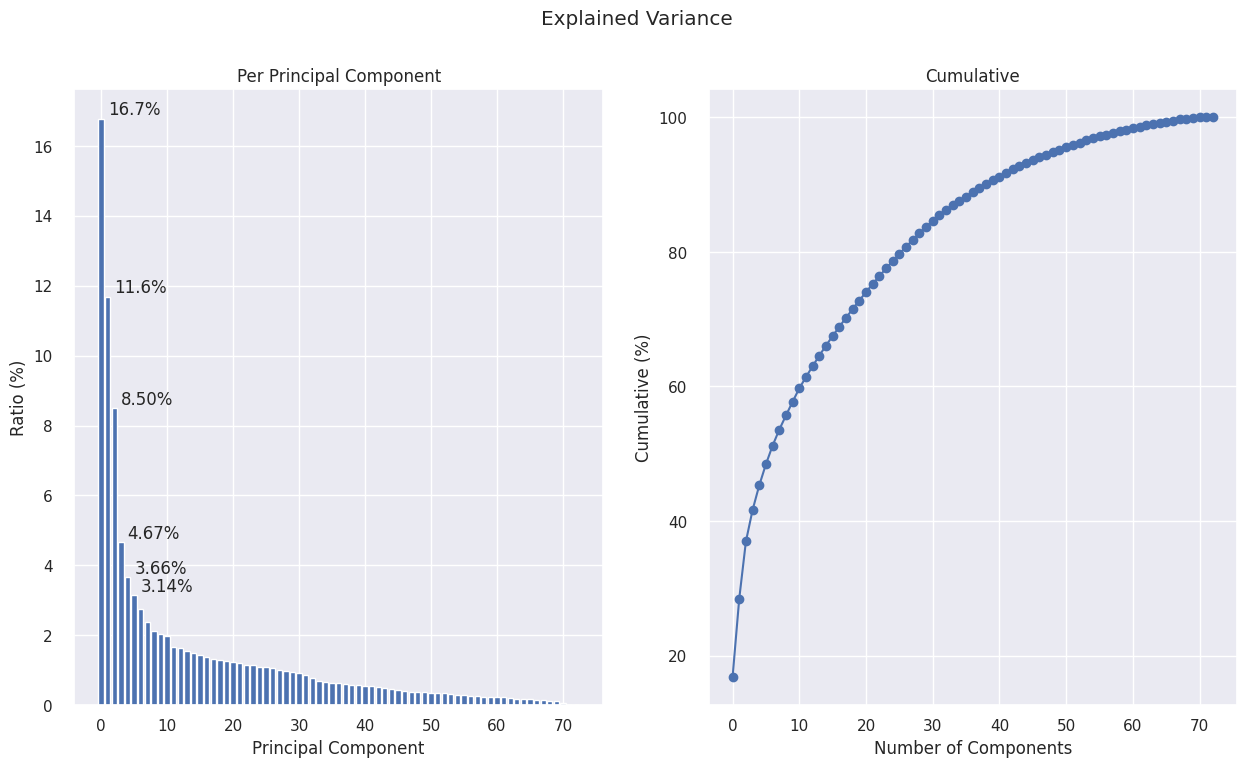

In [40]:
###############################################################################
## Apply PCA to the data and                                                 ## 
## Investigate the variance accounted for by each principal component        ##
############################################################################### 

pca = PCA(n_components = (data_ss.shape[1]))
pca_transformed_data = pca.fit_transform(data_ss)
plot_pca_explained_variance(pca)
if VERBOSE > 2:
    print(pca.explained_variance_ratio_)

### Discussion 2.2: Perform Dimensionality Reduction
The above two **Explained Variance** figures plot the amount of variance explained by each of the initial features available in the dataset (~80 features). 
 - Each bar of the left sub-plots represent a principlal component. We can see from the right sub-plot of the first figure, that 6 of the 80 components contain 50% of the entire variability present in the original dataset, with the sole first component being able to explain as much as 17.1% of the totale variability by its own.
 - From the right sub-plot we can also see that 70% of variability can be explained by 17 components while the 90% explainability requires 40 components.

At this point, **we would suggest to retain 40 components** out of 80 present for the next step of the analysis, as this set is enough to explain 90% the variance. 

In the next steps, we will investigate which are the main contributor components by plotting their PCA feature weights per dimensions.

### Step 2.3: Interpret Principal Components

```
Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.
```

In [41]:
def plot_pca_results(dataset, pca, dim, verbose=0):
    '''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
    Args:
        dataset (df) - The full dataset
        pca (pca-obj)- The pca object
        dim (int)    - The diemension to plot
    
    Returns:
      None
	'''        
    if verbose > 2 :
        print(f"The shape of the PCA weight matrix is {pca.components_.shape} ")
 
    # Assess the value of 'dim'
    if dim < 1 or dim > pca.components_.shape[1]:
        print(f"[ERROR] The dimension parameter ({dim}) is not in range!!!")
        sys.exit()
        
    # Retreive the matrix with the loadings of each feature on each principal
    #  component. Fyi, each row corresponds to a principal component, and each
    #  column corresponds to a feature.
    feature_weights = pca.components_
      
    # Extract the weights of dimension 'd'
    weights_dim = feature_weights[dim-1]
    
    # If you'd prefer the absolute values of the weights
    if 0:
        weights_dim = abs(weights_dim)

    # Create a dataframe with the feature weights of dimension 'd'
    feature_names = data_ss.columns
    df_weights_dim = pd.DataFrame(data=weights_dim, 
                                  columns=['Feature Weight'],
                                  index=feature_names)

    # Sort the dataframe by weights
    df_weights_dim = df_weights_dim.sort_values(by='Feature Weight',
                                                ascending=False)

    # Select a set of top contributors
    top_selection = (int)(pca.components_.shape[1]/1)
    top_features = df_weights_dim[:top_selection]
    
    if verbose > 0:
        num = 5
        print(f"### The top    {num} weights for principal component number-{dim} are ###")
        print(top_features.head(num))
        print("...")
        print(f"### The bottom {num} weights for principal component number-{dim} are ###")
        print(top_features.tail(num))
        
    # Create a new figure with the specified height
    plt.figure().set_figwidth(15)

    # Bar plot the weights 
    top_features.plot.bar()

    # Set the title and labels for the plot
    title = f"Feature Weights of Dimension {dim}"
    plt.title(title, fontsize=14)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Weight', fontsize=12)

    # Rotate the x-axis labels by 45 degrees and decrease font size
    plt.xticks(rotation=45, fontsize=4)
    
    # Decrease font size of yticks
    plt.yticks(fontsize=10)

    # Display the plot
    plt.show()


### The top    5 weights for principal component number-1 are ###
                        Feature Weight
PLZ8_ANTG3                    0.210560
PLZ8_ANTG4                    0.203285
HH_EINKOMMEN_SCORE            0.201844
CAMEO_INTL_2015_WEALTH        0.196628
ORTSGR_KLS9                   0.183515
...
### The bottom 5 weights for principal component number-1 are ###
                   Feature Weight
FINANZ_MINIMALIST       -0.210558
KBA05_ANTG1             -0.214270
LP_STATUS_GROB          -0.227496
LP_STATUS_FEIN          -0.230074
MOBI_REGIO              -0.233146


<Figure size 1500x480 with 0 Axes>

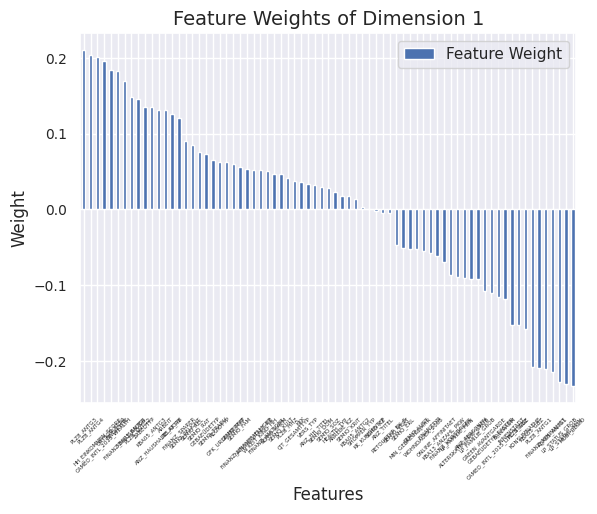

### The top    5 weights for principal component number-2 are ###
                      Feature Weight
ALTERSKATEGORIE_GROB        0.268853
SEMIO_ERL                   0.245409
FINANZ_VORSORGER            0.233856
SEMIO_LUST                  0.187157
RETOURTYP_BK_S              0.160113
...
### The bottom 5 weights for principal component number-2 are ###
               Feature Weight
SEMIO_KULT          -0.235988
SEMIO_PFLICHT       -0.237206
SEMIO_TRADV         -0.237673
FINANZ_SPARER       -0.242142
SEMIO_REL           -0.270381


<Figure size 1500x480 with 0 Axes>

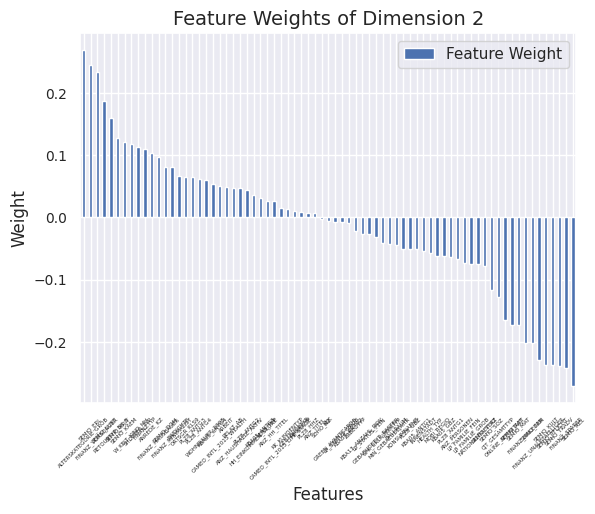

### The top    5 weights for principal component number-3 are ###
                   Feature Weight
SEMIO_VERT               0.333515
SEMIO_SOZ                0.251621
SEMIO_FAM                0.237132
SEMIO_KULT               0.221193
FINANZ_MINIMALIST        0.155504
...
### The bottom 5 weights for principal component number-3 are ###
            Feature Weight
SEMIO_RAT        -0.222292
SEMIO_KRIT       -0.262702
SEMIO_DOM        -0.304742
SEMIO_KAEM       -0.325267
ANREDE_KZ        -0.358510


<Figure size 1500x480 with 0 Axes>

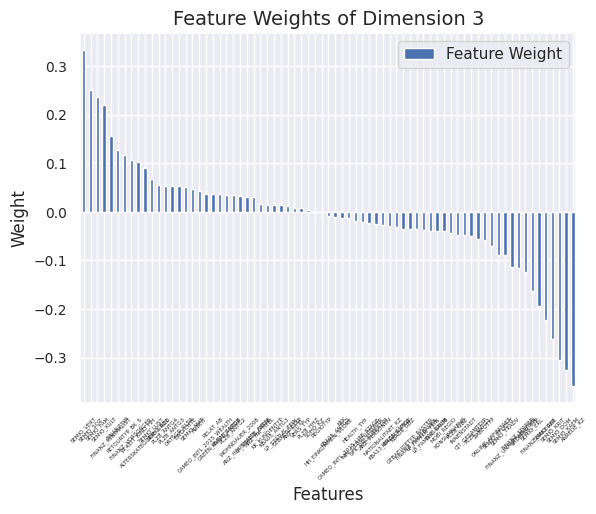

In [42]:
###############################################################################
## Plot the weights of the first 3 principal components and print the the    ##
## linked values, sorted by weight.                                          ##
###############################################################################
max_dimensions = 4
for d in range (1, max_dimensions):
    plot_pca_results(data_ss, pca, d, verbose=1)

### Discussion 2.3: Interpret Principal Components

In the [discussion 2.2 on Dimensionality Reduction](#discussion-22-perform-dimensionality-reduction), we mentioned that 
the first principal component was able to explain as much as 17.1% of the totale variability by its own. This component seems to dominantly group the populations by their `wealth` and their large `family houses` vs the correlated `social status` and the small `family houses` as shown by the following 5 top and 5 bottom features:
```
  PLZ8_ANTG3                 0.201566 # Number 6-10 family houses in PLZ8 region
  PLZ8_ANTG4                 0.195503 # Number 10+ family houses in PLZ8 region
  HH_EINKOMMEN_SCORE         0.191138 # Estimated household net income
  PLZ8_BAUMAX                0.190544 # Most common building type within PLZ8 region
  CAMEO_INTL_2015_WEALTH     0.185669 # Wealth / Int'l Life Stage Typology
  ...
  PLZ8_ANTG1                -0.200949 # Number 1-2 family houses in PLZ8 region
  KBA05_ANTG1               -0.202524 # Number 1-2 family houses in the microcell
  LP_STATUS_GROB            -0.215528 # Social status, rough scale
  LP_STATUS_FEIN            -0.218590 # Social status, fine scale
  MOBI_REGIO                -0.220937 # Movement patterns
```

The second principal component has the following 4 top and 4 bottom features. It seems to group `age`, `finacial typology` and personality`. 
```
  ALTERSKATEGORIE_GROB      0.264978 # Estimated age
  FINANZ_VORSORGER          0.242146 # Financial typology
  SEMIO_ERL                 0.224944 # Personality typology
  SEMIO_LUST                0.186449 # Personality typology
  ...
  SEMIO_PFLICHT            -0.236472 # Personality typology
  FINANZ_SPARER            -0.252164 # Financial typology
  SEMIO_REL                -0.256929 # Personality typology
  PRAEGENDE_JUGENDJAHRE    -0.262479 # Dominating movement of person's youth
```
Finally, the third component, mainly groups the populations per `personality topology` with this kind of feature being present in 4 out of 5 top and 5 bottoms features.   

[INFO]After re-applying PCA with 40 components we get a shape of (797936, 40) for 'pca_transformed_data' 


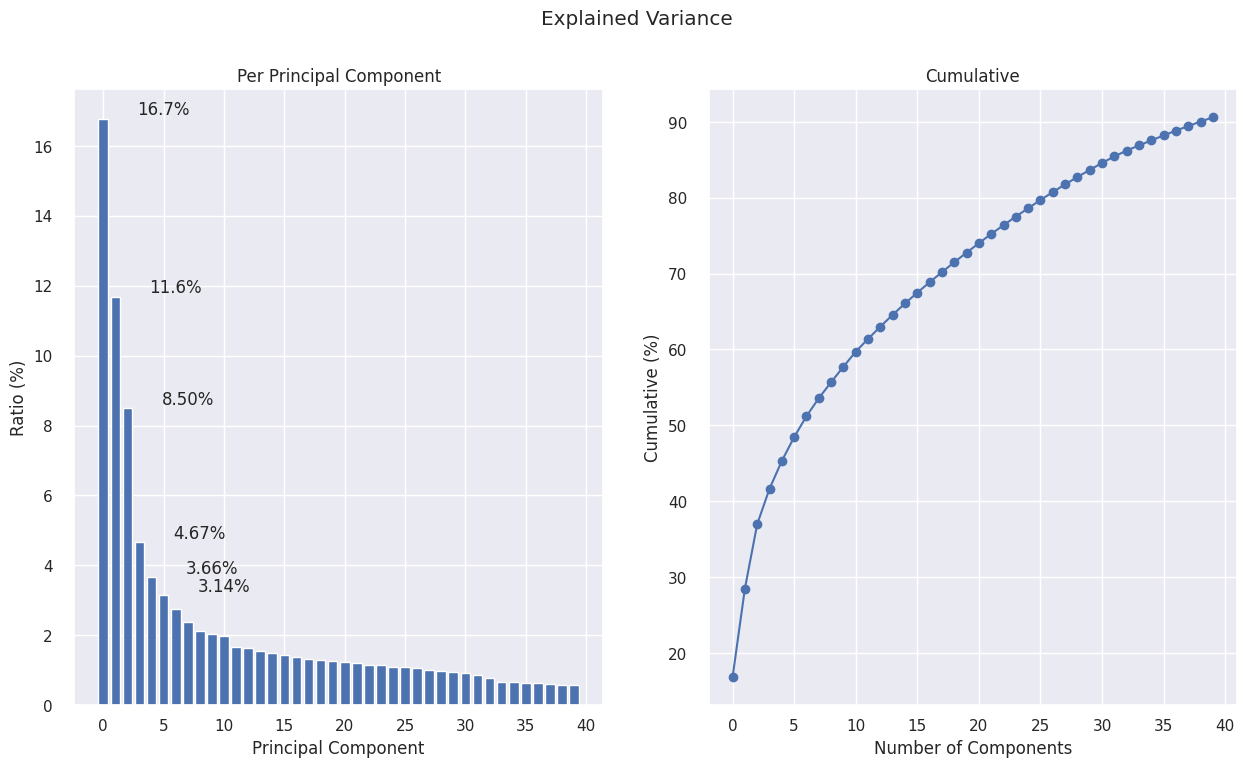

In [43]:
###############################################################################
## Re-apply PCA to data while selecting for number of components to retain   ##
###############################################################################

#OBSOLETE pca = PCA(n_components = (data_ss.shape[1]))
#OBSOLETE  pca_transformed_data = pca.fit_transform(data_ss

N_COMPS = 40

pca = PCA(n_components = N_COMPS)
pca_fit_data = pca.fit(data_ss)
pca_transformed_data = pca.transform(data_ss)

if VERBOSE:
    print(f"[INFO]After re-applying PCA with {N_COMPS} components we get a shape of {pca_transformed_data.shape} for \'pca_transformed_data\' ")

    plot_pca_explained_variance(pca)
    if VERBOSE > 2:
        print(pca.explained_variance_ratio_)


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

```
You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.
```

In [44]:
def get_kmeans_score(data, center):
    '''
    Returns the kmeans score regarding Sum of Squared Errors (SSE) for points to
    centers
    
    Args:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the K value)
    
    Returns:
        score - the SSE score for the kmeans model fit to the data
    '''
    # Instantiate K-Means
    #   Note: 'n_init' is the number of times the k-means algorithm is run with
    #     different centroid seeds. The final results is the best output of 'n_init'
    #     consecutive runs in terms of inertia. Several runs are recommended for
    #     sparse high-dimensional problems. This number is 10 by default.
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to the data
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    #  Note: The '.score' method returns the negative of the sum of squared distances
    #    of each sample to its closest centroid. In other words, it provides a measure
    #    of how well the data points are clustered together based on their distances
    #    to the centroids (the lower the better).
    score = np.abs(model.score(data))
    
    return score

In [45]:
######################################################################################
## Fit the data model on the PCA-transformed data and compute the score for a set   ## 
## of centroids from 1-10+                                                          ##
######################################################################################

scores = []
centers = list(range(1,15))

# Over a number of different cluster counts
for center in centers:
    scores.append(get_kmeans_score(pca_transformed_data, center))
    

/home/fab/Fab/SE4S/3-DS/3-UnsupervisedLearning/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/fab/Fab/SE4S/3-DS/3-UnsupervisedLearning/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/fab/Fab/SE4S/3-DS/3-UnsupervisedLearning/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/fab/Fab/SE4S/3-DS/3-UnsupervisedLearning/.venv/lib/p

In [ ]:
######################################################################################
## Investigate the change within-cluster distances across number of clusters        ## 
######################################################################################

plt.figure(figsize=(15, 5))
plt.plot(centers, scores, linestyle='-', marker='o', color='b')
plt.xlabel('Number of Clusters (K)', fontsize = 12)
plt.ylabel('Sum of Squared Errors (SSE)', fontsize = 12);
plt.title('Quality of the clustering solution vs. K \n (The lower The better)', 
          fontsize = 16)


In [ ]:
######################################################################################
# Re-fit the k-means model with the selected number of clusters and obtain cluster  ##
# predictions for the general population demographics data.                         ##
######################################################################################

# Instantiate K-Means with the selected number of cluster (Elbow Method)
kmeans = KMeans(n_clusters=12, random_state=4201)

# Then fit the model to the data
model_13 = kmeans.fit(pca_transformed_data)

# Predict the labels on the same data
azdias_13 = kmeans.predict(pca_transformed_data)


### Discussion 3.1: Apply Clustering to General Population

The average distance from the centroids represented by the SSE score seems to flatten down after ten to twelve clusters. The last significant drop is between K=11 and K=12, so I decided to use **K=12**. 

### Step 3.2: Apply All Steps to the Customer Data
```
Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.
```

In [ ]:
######################################################################################
## Load in the customer demographics data                                           ##
######################################################################################
customers_raw = pd.read_csv('./Udacity_CUSTOMERS_Subset.csv', sep=';')

# Load in the feature summary file (our clean_data function uses it)
feat_info_raw = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep=';')

######################################################################################
## Apply preprocessing, feature transformation, and clustering from the general     ##
## demographics onto the customer data, obtaining cluster predictions for the       ##
## customer demographics data.                                                      ##
######################################################################################

# Step-1: Feature wrangling, engineering and data cleaning
#   Note: It is assumed that the customer demographics data has similar meaning
customers, feat_info = clean_data(customers_raw, feat_info_raw, verbose=0)

# Step-2: Assess that the customers dataset is clean
nan_test = customers.isna()
if nan_test.sum().sum() != 0:
    print(f"[ERROR] Please check your data cleaning process. \n\tThey are {nan_test.sum().sum()} NaN values left in the supposedly clean customers dataset !!!")
    display(customers.head(4))
    sys.exit()
elif VERBOSE:
    print(f"[INFO] We are good to go with zero remaining NaN values left in the customers dataset.")

# Step-3: Apply feature scaling to the customers dataset (re-use the existing instance)
customers_ss = pd.DataFrame(scaler.fit_transform(customers), columns=customers.columns)
if VERBOSE > 2:
    print(f"[INFO] This is the feature scaled customers dataset")

print(f"SHAPE of customers_ss = {customers_ss.shape}")
    
# Step-4: Apply PCA transform to the customers datatset (do not 'fit' or 'fit_transform' here)

pca_transformed_customers = pca.transform(customers_ss)
# print(f"SHAPE of pca_transformed_customers = {pca_transformed_customers.shape}")


In [ ]:
print(customers_ss.shape)
#customers_ss = customers_ss.drop(['ALTER_HH'], axis=1)
customers_ss = customers_ss.drop(['OST_WEST_KZ'], axis=1)
print(customers_ss.shape)

In [ ]:

pca_transformed_customers = pca.transform(customers_ss)
print(data.shape)
print(customers.shape)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
######################################################################################
## What kinds of people are part of a cluster that is overrepresented in the        ##
## customer data compared to the general population?                                ##
######################################################################################




In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.